In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

print('GPU name: {}'.format(tf.test.gpu_device_name()))

2.4.1
GPU name: /device:GPU:0


# Sequence modelling 

## Coding tutorials
 #### 1.  The IMDb dataset
 #### 2. Padding and masking sequence data
 #### 3. The `Embedding` layer
 #### 4. The Embedding Projector
 #### 5. Recurrent neural network layers
 #### 6. Stacked RNNs and the `Bidirectional` wrapper

***
<a id="coding_tutorial_1"></a>
## The IMDb Dataset

#### Load the IMDB review sentiment dataset

In [ ]:
# Import imdb

import tensorflow.keras.datasets.imdb as imdb

In [ ]:
# Download and assign the data set using load_data()

(x_train, y_train), (x_test, y_test) = imdb.load_data()

17465344/17464789 [==============================] - 0s 0us/step


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

#### Inspect the dataset

In [ ]:
# Inspect the type of the data

type(x_train)

numpy.ndarray

In [ ]:
# Inspect the shape of the data
x_train.shape


(25000,)

In [ ]:
# Display the first dataset element input
# Notice encoding

x_train[0]

In [ ]:
# Display the first dataset element output
y_train[0]

1

#### Load dataset with different options

In [ ]:
# Load the dataset with defaults
imdb.load_data(path='imdb.npz',
        index_from=3)

# ~/.keras/dataset/

In [ ]:
# Limit the vocabulary to the top 500 words using num_words

imdb.load_data(num_words=1000)

In [ ]:
# Ignore the top 10 most frequent words using skip_top

imdb.load_data(skip_top=10, num_words=100,oov_char=2)

In [ ]:
# Limit the sequence lengths to 500 using maxlen

imdb.load_data(maxlen=500)

In [ ]:
 # Use '1' as the character that indicates the start of a sequence

 imdb.load_data(start_char=1)

#### Explore the dataset word index

In [ ]:
# Load the imdb word index using get_word_index()

imdb_word_index = imdb.get_word_index()

1646592/1641221 [==============================] - 0s 0us/step


In [ ]:
# View the word index as a dictionary,
# accounting for index_from.

index_from = 3
imdb_word_index = {key: value + index_from for key, value in imdb_word_index.items()}

In [ ]:
# Retrieve a specific word's index

imdb_word_index['simpsonian']

52256

In [ ]:
imdb_word_index['the']

4

In [ ]:
# View an input sentence
inv_imdb_word_index = {v: k for k, v in imdb_word_index.items()}
{inv_imdb_word_index[index] for index in x_train[0] if index > index_from}

{'a',
 'actor',
 'after',
 'all',
 'also',
 'amazing',
 'an',
 'and',
 'are',
 'as',
 'at',
 'be',
 'because',
 'been',
 'being',
 'big',
 'bought',
 "boy's",
 'brilliant',
 'but',
 'came',
 'casting',
 'children',
 'congratulations',
 'connection',
 'could',
 'cried',
 'cry',
 'definitely',
 'direction',
 'director',
 "don't",
 'done',
 'end',
 'everyone',
 "everyone's",
 'fact',
 'father',
 'film',
 'fishing',
 'fly',
 'for',
 'from',
 'good',
 'great',
 'grown',
 'have',
 'i',
 'if',
 'imagine',
 'is',
 'island',
 'it',
 'just',
 'know',
 'left',
 'life',
 'list',
 'little',
 'location',
 'loved',
 'lovely',
 'much',
 'must',
 'myself',
 'norman',
 "norman's",
 'now',
 'of',
 'often',
 'out',
 'part',
 "part's",
 'paul',
 'play',
 'played',
 'praised',
 'praising',
 'profile',
 'real',
 'really',
 'recommend',
 "redford's",
 'released',
 'remarks',
 'retail',
 'robert',
 'sad',
 'same',
 'say',
 'scenery',
 'scottish',
 'shared',
 'should',
 'so',
 "someone's",
 'soon',
 'stars',
 '

In [ ]:
# Get the sentiment value
y_train[0]

1

---
<a id="coding_tutorial_2"></a>
## Padding and Masking Sequence Data

In [ ]:
# Load the imdb data set

import tensorflow.keras.datasets.imdb as imdb
(x_train, y_train),(x_test, y_test) = imdb.load_data()

17465344/17464789 [==============================] - 0s 0us/step


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

#### Preprocess the data with padding

In [ ]:
# Inspect the input data shape

x_train.shape

(25000,)

In [ ]:
# Pad the inputs to the maximum length using maxlen

padded_x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train, maxlen=300, padding='post', truncating='pre')

In [ ]:
# Inspect the output data shape

padded_x_train.shape

(25000, 300)

#### Create a Masking layer

In [ ]:
# Import numpy 
import numpy as np


In [ ]:
# Masking expects to see (batch, sequence, features)
# Create a dummy feature dimension using expand_dims

padded_x_train = np.expand_dims(padded_x_train, -1)

In [ ]:
# Create a Masking layer 
tf_x_train = tf.convert_to_tensor(padded_x_train, dtype='float32')
masking_layer = tf.keras.layers.Masking(mask_value=0.0)

In [ ]:
# Pass tf_x_train to it

masked_x_train = masking_layer(tf_x_train)

In [ ]:
# Look at the dataset

# tf_x_train
masked_x_train

<tf.Tensor: shape=(25000, 300, 1), dtype=float32, numpy=
array([[[1.000e+00],
        [1.400e+01],
        [2.200e+01],
        ...,
        [0.000e+00],
        [0.000e+00],
        [0.000e+00]],

       [[1.000e+00],
        [1.940e+02],
        [1.153e+03],
        ...,
        [0.000e+00],
        [0.000e+00],
        [0.000e+00]],

       [[1.000e+00],
        [1.400e+01],
        [4.700e+01],
        ...,
        [0.000e+00],
        [0.000e+00],
        [0.000e+00]],

       ...,

       [[1.000e+00],
        [1.100e+01],
        [6.000e+00],
        ...,
        [0.000e+00],
        [0.000e+00],
        [0.000e+00]],

       [[1.000e+00],
        [1.446e+03],
        [7.079e+03],
        ...,
        [0.000e+00],
        [0.000e+00],
        [0.000e+00]],

       [[1.000e+00],
        [1.700e+01],
        [6.000e+00],
        ...,
        [0.000e+00],
        [0.000e+00],
        [0.000e+00]]], dtype=float32)>

In [ ]:
# Look at the ._keras_mask for the dataset

masked_x_train._keras_mask

<tf.Tensor: shape=(25000, 300), dtype=bool, numpy=
array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])>

***
<a id="coding_tutorial_3"></a>
## The Embedding layer

#### Create and apply an `Embedding` layer

In [ ]:
# Create an embedding layer using layers.Embedding
# Specify input_dim, output_dim, input_length

embedding_layer = tf.keras.layers.Embedding(input_dim=501,output_dim=16)   

In [ ]:
# Inspect an Embedding layer output for a fixed input
# Expects an input of shape (batch, sequence, feature)

sequence_of_indices = tf.constant([[[0],[1],[5],[500]]])
sequence_of_embeddings = embedding_layer(sequence_of_indices)
sequence_of_embeddings

<tf.Tensor: shape=(1, 4, 1, 16), dtype=float32, numpy=
array([[[[-0.04345442, -0.02358326, -0.00449814,  0.03837085,
           0.00315964, -0.02534742, -0.01886117, -0.00353088,
           0.00641876,  0.02003745,  0.04511331,  0.04326515,
          -0.01689699,  0.02234134, -0.01641585,  0.00714906]],

        [[ 0.03641764,  0.02512434,  0.0063277 , -0.03532399,
           0.00449105, -0.03822051, -0.04279244,  0.02152503,
           0.02254109, -0.03280412,  0.03400621, -0.04372631,
          -0.04770545,  0.02589626,  0.00747253, -0.02199592]],

        [[ 0.02028384, -0.04733639, -0.01696197,  0.01678916,
          -0.01203877,  0.00728469, -0.03355328,  0.04767741,
           0.00683041, -0.04442517, -0.017888  ,  0.00935989,
          -0.00257634,  0.04242475,  0.01452954, -0.0352296 ]],

        [[-0.04792767,  0.02264715,  0.03377462,  0.01465033,
          -0.01785503, -0.01687647, -0.03984711, -0.02543566,
           0.02434281, -0.03035879, -0.00282913,  0.00339116,
      

In [ ]:
# Inspect the Embedding layer weights using get_weights()

embedding_layer.get_weights()[0]

array([[-0.04345442, -0.02358326, -0.00449814, ...,  0.02234134,
        -0.01641585,  0.00714906],
       [ 0.03641764,  0.02512434,  0.0063277 , ...,  0.02589626,
         0.00747253, -0.02199592],
       [ 0.02314026,  0.03134802,  0.04846058, ...,  0.02126486,
        -0.00622009, -0.00258306],
       ...,
       [ 0.04970534,  0.01900531,  0.00811747, ..., -0.01144379,
         0.01168002,  0.03859324],
       [ 0.0193478 ,  0.0417085 , -0.01302254, ..., -0.00927367,
        -0.03650811,  0.02172002],
       [-0.04792767,  0.02264715,  0.03377462, ...,  0.04103805,
        -0.03301231, -0.03078488]], dtype=float32)

In [ ]:
# Get the embedding for the 14th index
embedding_layer.get_weights()[0][14,:]

array([-0.03285192, -0.0179473 ,  0.03549613,  0.03543414, -0.00109488,
        0.04181694,  0.04338996, -0.02111155, -0.0059041 , -0.03623816,
       -0.0452342 , -0.02571621, -0.04395909, -0.01026515, -0.01241706,
        0.01868248], dtype=float32)

#### Create and apply an `Embedding` layer that uses `mask_zero=True`

In [ ]:
# Create a layer that uses the mask_zero kwarg

masking_embedding_layer = tf.keras.layers.Embedding(input_dim=501, output_dim=16, mask_zero=True)

In [ ]:
# Apply this layer to the sequence and see the _keras_mask property
masked_sequence_of_embedding = masking_embedding_layer(sequence_of_indices)
masked_sequence_of_embedding._keras_mask

<tf.Tensor: shape=(1, 4, 1), dtype=bool, numpy=
array([[[False],
        [ True],
        [ True],
        [ True]]])>

---
<a id="coding_tutorial_4"></a>
## The Embedding Projector

#### Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


#### Load and preprocess the IMDb data

In [ ]:
# A function to load and preprocess the IMDB dataset

def get_and_pad_imdb_dataset(num_words=10000, maxlen=None, index_from=2):
    from tensorflow.keras.datasets import imdb

    # Load the reviews
    (x_train, y_train), (x_test, y_test) = imdb.load_data(path='imdb.npz',
                                                          num_words=num_words,
                                                          skip_top=0,
                                                          maxlen=maxlen,
                                                          start_char=1,
                                                          oov_char=2,
                                                          index_from=index_from)

    x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train,
                                                        maxlen=None,
                                                        padding='pre',
                                                        truncating='pre',
                                                        value=0)
    
    x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test,
                                                           maxlen=None,
                                                           padding='pre',
                                                           truncating='pre',
                                                           value=0)
    return (x_train, y_train), (x_test, y_test)

In [ ]:
# Load the dataset

(x_train, y_train),(x_test, y_test) = get_and_pad_imdb_dataset()

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

In [ ]:
# A function to get the dataset word index

def get_imdb_word_index(num_words=10000, index_from=2):
    imdb_word_index = tf.keras.datasets.imdb.get_word_index(
                                        path='imdb_word_index.json')
    imdb_word_index = {key: value + index_from for
                       key, value in imdb_word_index.items() if value <= num_words-index_from}
    return imdb_word_index

In [ ]:
# Get the word index

imdb_word_index = get_imdb_word_index()

1646592/1641221 [==============================] - 0s 0us/step


In [ ]:
# Swap the keys and values of the word index

inv_imdb_word_index = { v:k for k, v in imdb_word_index.items()}

In [ ]:
# View the first dataset example sentence

[inv_imdb_word_index[index] for index in x_train[100] if index > 2]

['i',
 'am',
 'a',
 'great',
 'fan',
 'of',
 'david',
 'lynch',
 'and',
 'have',
 'everything',
 'that',
 "he's",
 'made',
 'on',
 'dvd',
 'except',
 'for',
 'hotel',
 'room',
 'the',
 '2',
 'hour',
 'twin',
 'peaks',
 'movie',
 'so',
 'when',
 'i',
 'found',
 'out',
 'about',
 'this',
 'i',
 'immediately',
 'grabbed',
 'it',
 'and',
 'and',
 'what',
 'is',
 'this',
 "it's",
 'a',
 'bunch',
 'of',
 'drawn',
 'black',
 'and',
 'white',
 'cartoons',
 'that',
 'are',
 'loud',
 'and',
 'foul',
 'mouthed',
 'and',
 'unfunny',
 'maybe',
 'i',
 "don't",
 'know',
 "what's",
 'good',
 'but',
 'maybe',
 'this',
 'is',
 'just',
 'a',
 'bunch',
 'of',
 'crap',
 'that',
 'was',
 'on',
 'the',
 'public',
 'under',
 'the',
 'name',
 'of',
 'david',
 'lynch',
 'to',
 'make',
 'a',
 'few',
 'bucks',
 'too',
 'let',
 'me',
 'make',
 'it',
 'clear',
 'that',
 'i',
 "didn't",
 'care',
 'about',
 'the',
 'foul',
 'language',
 'part',
 'but',
 'had',
 'to',
 'keep',
 'the',
 'sound',
 'because',
 'my',
 'ne

#### Build an Embedding layer into a model

In [ ]:
# Get the maximum token value

max_index_value = max(imdb_word_index.values())

In [ ]:
max_index_value

10000

In [ ]:
# Specify an embedding dimension

embedding_dim =16

In [ ]:
# Build a model using Sequential:
#     1. Embedding layer
#     2. GlobalAveragePooling1D
#     3. Dense

model = tf.keras.Sequential([
        tf.keras.layers.Embedding(input_dim=max_index_value+1,output_dim=embedding_dim, mask_zero=False),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(units=1, activation='sigmoid')
])


In [ ]:
# Functional API refresher: use the Model to build the same model

review_sequece = tf.keras.Input((None,))
embedding_sequence = tf.keras.layers.Embedding(input_dim=max_index_value+1, output_dim=embedding_dim, mask_zero=False)(review_sequece)
average_embedding = tf.keras.layers.GlobalAveragePooling1D()(embedding_sequence)
positive_propablility = tf.keras.layers.Dense(units=1, activation='sigmoid')(average_embedding)

model2 = tf.keras.Model(inputs=review_sequece, outputs=positive_propablility)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160016    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model2.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_3 (Embedding)      (None, None, 16)          160016    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


#### Compile, train, and evaluate the model

In [ ]:
# Compile the model with a binary cross-entropy loss

model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')

In [ ]:
# Train the model using .fit(), savng its history

history = model.fit(x_train, y_train, epochs=5, batch_size=32, validation_data=(x_test,y_test), validation_steps=20)

Epoch 1/5
782/782 [==============================] - 9s 9ms/step - loss: 0.6919 - accuracy: 0.5204 - val_loss: 0.6822 - val_accuracy: 0.5828
Epoch 2/5
782/782 [==============================] - 6s 8ms/step - loss: 0.6772 - accuracy: 0.6663 - val_loss: 0.6511 - val_accuracy: 0.7422
Epoch 3/5
782/782 [==============================] - 6s 8ms/step - loss: 0.6396 - accuracy: 0.7453 - val_loss: 0.6051 - val_accuracy: 0.7484
Epoch 4/5
782/782 [==============================] - 6s 8ms/step - loss: 0.5894 - accuracy: 0.7813 - val_loss: 0.5540 - val_accuracy: 0.7812
Epoch 5/5
782/782 [==============================] - 6s 8ms/step - loss: 0.5445 - accuracy: 0.8042 - val_loss: 0.5147 - val_accuracy: 0.7844


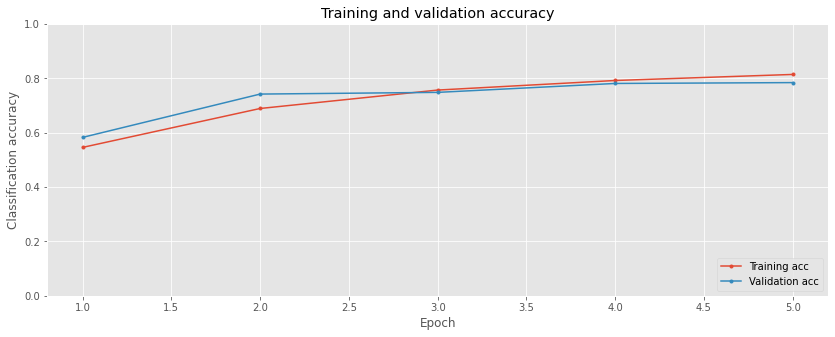

In [ ]:
# Plot the training and validation accuracy

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

history_dict = history.history

acc      = history_dict['accuracy']
val_acc  = history_dict['val_accuracy']
loss     = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14,5))
plt.plot(epochs, acc, marker='.', label='Training acc')
plt.plot(epochs, val_acc, marker='.', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Classification accuracy')
plt.legend(loc='lower right')
plt.ylim(0, 1);

#### The TensorFlow embedding projector

The Tensorflow embedding projector can be found [here](https://projector.tensorflow.org/).

In [ ]:
# Retrieve the embedding layer's weights from the trained model

weights = model.layers[0].get_weights()[0]

In [ ]:
!ls 'drive/MyDrive/Colab Notebooks'

 accelerometer
'“Additional callbacks.ipynb”的副本'
 ai-platform-text-classifier-shap.ipynb
 colab_driver_github.ipynb
 “colab_driver_github.ipynb”的副本
 coursera
'“Device placement.ipynb”的副本'
 “eager.ipynb”的副本
 keras_overview.ipynb
 LearnFromKaggler
 pandas-tutorial
 position_encoding.ipynb
 SetUp.ipynb
 style_transfer.ipynb
 tf2_SaveAndRestoreModels.ipynb
'TF-Hub: Fast Style Transfer for Arbitrary Styles.ipynb'
 tfrecord.ipynb
 “tfrecord.ipynb”的副本
 “transformer.ipynb”的副本
'“Week 2 Programming Assignment.ipynb”的副本'
'“Week 3 Programming Assignment.ipynb”的副本'
'“外部数据：本地文件、Google 云端硬盘、Google 表格和 Cloud Storage”的副本'


In [ ]:
# Save the word Embeddings to tsv files
# Two files: 
#     one contains the embedding labels (meta.tsv),
#     one contains the embeddings (vecs.tsv)

import io
from os import path

# out_v = io.open(path.join('data', 'vecs.tsv'), 'w', encoding='utf-8')
# out_m = io.open(path.join('data', 'meta.tsv'), 'w', encoding='utf-8')
out_v = io.open(path.join('drive/MyDrive/Colab Notebooks', 'vecs.tsv'), 'w', encoding='utf-8')
out_m = io.open(path.join('drive/MyDrive/Colab Notebooks', 'meta.tsv'), 'w', encoding='utf-8')
k = 0

for word, token in imdb_word_index.items():
    if k != 0:
        out_m.write('\n')
        out_v.write('\n')
    
    out_v.write('\t'.join([str(x) for x in weights[token]]))
    out_m.write(word)
    k += 1
    
out_v.close()
out_m.close()
# beware large collections of embeddings!

---
<a id="coding_tutorial_5"></a>
## Recurrent neural network layers

#### Initialize and pass an input to a SimpleRNN layer

In [ ]:
# Create a SimpleRNN layer and test it

# batch, sequence, features
simplernn_layer = tf.keras.layers.SimpleRNN(units=16)

In [ ]:
# Note that only the final cell output is returned

sequence = tf.constant([[[1.,1.], [2.,3.], [56., 43.]]])
layer_output = simplernn_layer(sequence)
layer_output

<tf.Tensor: shape=(1, 16), dtype=float32, numpy=
array([[-0.99999976, -0.99999976, -0.99999976,  0.99993235,  0.9895825 ,
        -0.99998605, -0.9999767 ,  0.98221654, -0.99999976, -0.99999976,
        -0.99999976, -0.99999976, -0.99999976,  0.99999976, -0.99999976,
        -0.99999976]], dtype=float32)>

#### Load and transform the IMDB review sentiment dataset

In [ ]:
# A function to load and preprocess the IMDB dataset

def get_and_pad_imdb_dataset(num_words=10000, maxlen=None, index_from=2):
    from tensorflow.keras.datasets import imdb

    # Load the reviews
    (x_train, y_train), (x_test, y_test) = imdb.load_data(path='imdb.npz',
                          num_words=num_words,
                          skip_top=0,
                          maxlen=maxlen,
                          start_char=1,
                          oov_char=2,
                          index_from=index_from)

    x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train,
                          maxlen=None,
                          padding='pre',
                          truncating='pre',
                          value=0)
    
    x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test,
                          maxlen=None,
                          padding='pre',
                          truncating='pre',
                          value=0)
    return (x_train, y_train), (x_test, y_test)

In [ ]:
# Load the dataset

(x_train, y_train), (x_test, y_test) = get_and_pad_imdb_dataset(maxlen=250)


17465344/17464789 [==============================] - 0s 0us/step


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

In [ ]:
# A function to get the dataset word index

def get_imdb_word_index(num_words=10000, index_from=2):
    imdb_word_index = tf.keras.datasets.imdb.get_word_index(
                                        path='imdb_word_index.json')
    imdb_word_index = {key: value + index_from for
                       key, value in imdb_word_index.items() if value <= num_words-index_from}
    return imdb_word_index

In [ ]:
# Get the word index using get_imdb_word_index()

imdb_word_index = get_imdb_word_index()

1646592/1641221 [==============================] - 0s 0us/step


#### Create a recurrent neural network model

In [ ]:
# Get the maximum index value

max_index_value = max(imdb_word_index.values())
embedding_dim = 16


In [ ]:
max_index_value

10000

In [ ]:
# Using Sequential, build the model:
# 1. Embedding.
# 2. LSTM.
# 3. Dense.

model = tf.keras.Sequential([
          tf.keras.layers.Embedding(input_dim=max_index_value+1, output_dim=embedding_dim, mask_zero=True),
          tf.keras.layers.LSTM(units=16),
          tf.keras.layers.Dense(units=1, activation='sigmoid')
])

#### Compile and fit the model

In [ ]:
# Compile the model with binary cross-entropy loss

model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')

In [ ]:
# Fit the model and save its training history

history = model.fit(x_train, y_train, epochs=3, batch_size=32)

Epoch 1/3
536/536 [==============================] - 284s 524ms/step - loss: 0.6278 - accuracy: 0.6386
Epoch 2/3
536/536 [==============================] - 278s 518ms/step - loss: 0.2740 - accuracy: 0.8968
Epoch 3/3
536/536 [==============================] - 269s 502ms/step - loss: 0.1845 - accuracy: 0.9378


#### Plot learning curves

In [ ]:
# Plot the training and validation accuracy

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

history_dict = history.history

acc      = history_dict['accuracy']
val_acc  = history_dict['val_accuracy']
loss     = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14,5))
plt.plot(epochs, acc, marker='.', label='Training acc')
plt.plot(epochs, val_acc, marker='.', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Classification accuracy')
plt.legend(loc='lower right')
plt.ylim(0, 1);

KeyError: ignored

#### Make predictions with the model

In [ ]:
# View the first test data example sentence
# (invert the word index)

inv_imdb_word_index = {v:k for k,v in imdb_word_index.items()}
[inv_imdb_word_index[index] for index in x_test[0] if index >2 ]

['please',
 'give',
 'this',
 'one',
 'a',
 'miss',
 'br',
 'br',
 'and',
 'the',
 'rest',
 'of',
 'the',
 'cast',
 'rendered',
 'terrible',
 'performances',
 'the',
 'show',
 'is',
 'flat',
 'flat',
 'flat',
 'br',
 'br',
 'i',
 "don't",
 'know',
 'how',
 'michael',
 'madison',
 'could',
 'have',
 'allowed',
 'this',
 'one',
 'on',
 'his',
 'plate',
 'he',
 'almost',
 'seemed',
 'to',
 'know',
 'this',
 "wasn't",
 'going',
 'to',
 'work',
 'out',
 'and',
 'his',
 'performance',
 'was',
 'quite',
 'so',
 'all',
 'you',
 'madison',
 'fans',
 'give',
 'this',
 'a',
 'miss']

In [ ]:
# Get the model prediction using model.predict()

model.predict(x_test[None, 0, :])

array([[0.01569305]], dtype=float32)

In [ ]:
# Get the corresponding label

y_test[0]

0

---
<a id="coding_tutorial_6"></a>
## Stacked RNNs and the Bidirectional wrapper

#### Load and transform the IMDb review sentiment dataset

In [ ]:
# A function to load and preprocess the IMDB dataset

def get_and_pad_imdb_dataset(num_words=10000, maxlen=None, index_from=2):
    from tensorflow.keras.datasets import imdb

    # Load the reviews
    (x_train, y_train), (x_test, y_test) = imdb.load_data(path='imdb.npz',
                                num_words=num_words,
                                skip_top=0,
                                maxlen=maxlen,
                                start_char=1,
                                oov_char=2,
                                index_from=index_from)

    x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train,
                                maxlen=None,
                                padding='pre',
                                truncating='pre',
                                value=0)
    
    x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test,
                              maxlen=None,
                              padding='pre',
                              truncating='pre',
                              value=0)
    return (x_train, y_train), (x_test, y_test)

In [ ]:
# Load the dataset

(x_trian, y_train),(x_test, y_test) = get_and_pad_imdb_dataset(num_words=5000, maxlen=250)

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

In [ ]:
# A function to get the dataset word index

def get_imdb_word_index(num_words=10000, index_from=2):
    imdb_word_index = tf.keras.datasets.imdb.get_word_index(
                                        path='imdb_word_index.json')
    imdb_word_index = {key: value + index_from for
                       key, value in imdb_word_index.items() if value <= num_words-index_from}
    return imdb_word_index

In [ ]:
# Get the word index using get_imdb_word_index()

imdb_word_index = get_imdb_word_index(num_words=5000)

#### Build stacked and bidirectional recurrent models

In [ ]:
# Get the maximum index value and specify an embedding dimension

max_index_value = max(imdb_word_index.values())
embedding_dim = 16

In [ ]:
# Using Sequential, build a stacked LSTM model via return_sequences=True

model = tf.keras.Sequential([
              tf.keras.layers.Embedding(input_dim=max_index_value+1, output_dim=embedding_dim, mask_zero=True),
              tf.keras.layers.LSTM(units=32, return_sequences=True),
              tf.keras.layers.LSTM(units=32, return_sequences=False),
              tf.keras.layers.Dense(units=1, activation='sigmoid')
])

In [ ]:
# Using Sequential, build a bidirectional RNN with merge_mode='sum'

# merge mode : sum mul concat ave    

model = tf.keras.Sequential([
              tf.keras.layers.Embedding(input_dim=max_index_value+1, output_dim=embedding_dim, mask_zero=True),
              tf.keras.layers.Bidirectional(layer=tf.keras.layers.LSTM(units=8),merge_mode='sum',
                            backward_layer=tf.keras.layers.GRU(units=8,go_backwards=True)),      
              tf.keras.layers.Dense(units=1, activation='sigmoid')
])

In [ ]:
# Create a model featuring both stacked recurrent layers and a bidirectional layer

model = tf.keras.Sequential([
              tf.keras.layers.Embedding(input_dim=max_index_value+1, output_dim=embedding_dim, mask_zero=True),
              tf.keras.layers.Bidirectional(layer=tf.keras.layers.LSTM(units=8,return_sequences=True),merge_mode='concat'),
              tf.keras.layers.GRU(units=8, return_sequences=False),
              tf.keras.layers.Dense(units=1, activation='sigmoid')                             
])

In [ ]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, None, 16)          80016     
_________________________________________________________________
bidirectional_8 (Bidirection (None, None, 16)          1600      
_________________________________________________________________
gru_8 (GRU)                  (None, 8)                 624       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 82,249
Trainable params: 82,249
Non-trainable params: 0
_________________________________________________________________


#### Compile and fit the model

In [ ]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, None, 16)          80016     
_________________________________________________________________
bidirectional_7 (Bidirection (None, 8)                 1424      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 9         
Total params: 81,449
Trainable params: 81,449
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compile the model

model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')

In [ ]:
# Train the model, saving its history

history = model.fit(x_train, y_train, epochs=3, batch_size=32)

Epoch 1/3


InvalidArgumentError: ignored

In [ ]:
# Plot the training and validation accuracy

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

history_dict = history.history

acc      = history_dict['accuracy']
val_acc  = history_dict['val_accuracy']
loss     = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14,5))
plt.plot(epochs, acc, marker='.', label='Training acc')
plt.plot(epochs, val_acc, marker='.', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Classification accuracy')
plt.legend(loc='lower right')
plt.ylim(0, 1);